In [1]:
# Importing Required Libraries
import cv2 
import numpy as np
import tensorflow 
import keras 
import matplotlib.pyplot as plt 
import keras_tuner as kt
from tensorflow.keras.models import load_model
from keras.layers import Activation

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adamax
from tensorflow.keras import regularizers
from keras.models import Model,Sequential 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, Conv2D, MaxPooling2D
from keras.applications import ResNet50, VGG16,VGG19, MobileNet
from keras.applications.efficientnet import EfficientNetB0, EfficientNetB3
from keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger,TensorBoard, ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Generators
train = ImageDataGenerator(rotation_range=90,horizontal_flip = True, vertical_flip =True, rescale = 1./255, shear_range = 0.2,
                                   zoom_range = 0.2)
valid = ImageDataGenerator(rescale = 1./255)

test = ImageDataGenerator(rescale = 1./255)

In [3]:
training = train.flow_from_directory(r'/kaggle/input/cards-image-datasetclassification/train', target_size = (224,224),class_mode = 'sparse',batch_size=32)
validation = valid.flow_from_directory(r'/kaggle/input/cards-image-datasetclassification/valid',target_size = (224,224),class_mode = 'sparse',batch_size = 32)
testing = test.flow_from_directory(r'/kaggle/input/cards-image-datasetclassification/test', target_size = (224,224),class_mode = 'sparse',batch_size=32)

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## EfficientNetB3 Architecture

In [4]:
base_model = EfficientNetB3(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max') 

base_model.trainable=True

base_model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescal

In [7]:
def build_model(hp):
    model = Sequential()
    
    model.add(base_model)
    model.add(Flatten())

    # Tune the number of units in the dense layer
    model.add(Dense(units=hp.Int("dense_units", min_value=128, max_value=300),
                    activation=hp.Choice("activation", values=["sigmoid", "tanh", "relu"]),
                    kernel_initializer=hp.Choice("weight_init", values=["glorot_uniform", "glorot_normal", "he_uniform", "he_normal"])))
    
    # Add BatchNormalization before activation
    model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    
    # Add Dense layer with regularizers
    model.add(Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
                    activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006)))
    
    # Activation layer should follow BatchNormalization
    model.add(Activation('relu'))
    
    # Add Dropout layer
    model.add(Dropout(rate=0.45, seed=123))
    model.add(Dense(53, activation='softmax'))
    
    optimizer_choice = hp.Choice('optimizer', values=['sgd', 'adam', 'rmsprop', 'adadelta'])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_choice, metrics=['accuracy'])
    return model

In [8]:
tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=5,directory=r"tuner_models_2")

tuner.search(training, epochs=20, validation_data=validation)

Trial 5 Complete [00h 41m 53s]
val_accuracy: 0.7132075428962708

Best val_accuracy So Far: 0.8037735819816589
Total elapsed time: 03h 27m 10s


In [9]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 300, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'tanh', 'relu'], 'ordered': False}
weight_init (Choice)
{'default': 'glorot_uniform', 'conditions': [], 'values': ['glorot_uniform', 'glorot_normal', 'he_uniform', 'he_normal'], 'ordered': False}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam', 'rmsprop', 'adadelta'], 'ordered': False}


In [10]:
tuner.results_summary()

Results summary
Results in tuner_models_2/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
dense_units: 255
activation: sigmoid
weight_init: he_normal
optimizer: sgd
Score: 0.8037735819816589

Trial 4 summary
Hyperparameters:
dense_units: 287
activation: tanh
weight_init: he_normal
optimizer: adadelta
Score: 0.7132075428962708

Trial 3 summary
Hyperparameters:
dense_units: 172
activation: sigmoid
weight_init: he_normal
optimizer: adadelta
Score: 0.7056604027748108

Trial 1 summary
Hyperparameters:
dense_units: 195
activation: tanh
weight_init: glorot_uniform
optimizer: sgd
Score: 0.5924528241157532

Trial 0 summary
Hyperparameters:
dense_units: 214
activation: sigmoid
weight_init: he_uniform
optimizer: sgd
Score: 0.44528302550315857


In [11]:
tuner.get_best_hyperparameters()[0].values

{'dense_units': 255,
 'activation': 'sigmoid',
 'weight_init': 'he_normal',
 'optimizer': 'sgd'}

In [12]:
fmodel = tuner.get_best_models(num_models = 1)[0]
fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 255)               391935    
                                                                 
 batch_normalization (Batch  (None, 255)               1020      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               65536     
                                                                 
 activation (Activation)     (None, 256)               0

In [13]:
es=EarlyStopping(monitor="val_loss",min_delta=0.1,patience=3,start_from_epoch=4,verbose=1) 

mc=ModelCheckpoint(r"model_checkpoint\model{epoch}.h5",monitor='val_loss',verbose=1,save_best_only=True)

re = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2,verbose=1, min_lr=1e-7)

In [14]:
csv=CSVLogger(r"log.csv")
tb=TensorBoard(log_dir=r"tensorboard\logdir",histogram_freq=1)

In [16]:
history = fmodel.fit_generator(training,steps_per_epoch = 7624 //32, 
                           epochs = 50,validation_data = validation , 
                           validation_steps = 265//32 , callbacks = [tb, mc, csv])

/tmp/ipykernel_47/938530648.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = fmodel.fit_generator(training,steps_per_epoch = 7624 //32,


Epoch 1/50


2023-12-05 15:22:02.816768: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


238/238 [==============================] - ETA: 0s - loss: 1.6417 - accuracy: 0.7318
Epoch 1: val_loss improved from inf to 2.48301, saving model to model_checkpoint\model1.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


238/238 [==============================] - 160s 531ms/step - loss: 1.6417 - accuracy: 0.7318 - val_loss: 2.4830 - val_accuracy: 0.4922
Epoch 2/50
238/238 [==============================] - ETA: 0s - loss: 1.5851 - accuracy: 0.7450
Epoch 2: val_loss improved from 2.48301 to 1.30973, saving model to model_checkpoint\model2.h5
238/238 [==============================] - 124s 520ms/step - loss: 1.5851 - accuracy: 0.7450 - val_loss: 1.3097 - val_accuracy: 0.8125
Epoch 3/50
238/238 [==============================] - ETA: 0s - loss: 1.5059 - accuracy: 0.7566
Epoch 3: val_loss did not improve from 1.30973
238/238 [==============================] - 123s 516ms/step - loss: 1.5059 - accuracy: 0.7566 - val_loss: 1.8338 - val_accuracy: 0.6406
Epoch 4/50
238/238 [==============================] - ETA: 0s - loss: 1.4754 - accuracy: 0.7603
Epoch 4: val_loss did not improve from 1.30973
238/238 [==============================] - 123s 515ms/step - loss: 1.4754 - accuracy: 0.7603 - val_loss: 1.3738 - val_

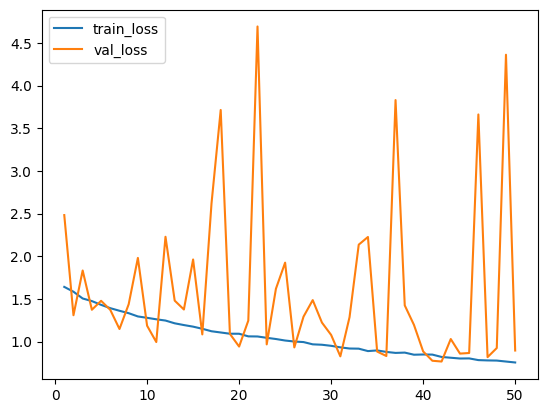

In [18]:
plt.plot(range(1,51),history.history["loss"],label="train_loss")
plt.plot(range(1,51),history.history["val_loss"],label="val_loss")
plt.legend()

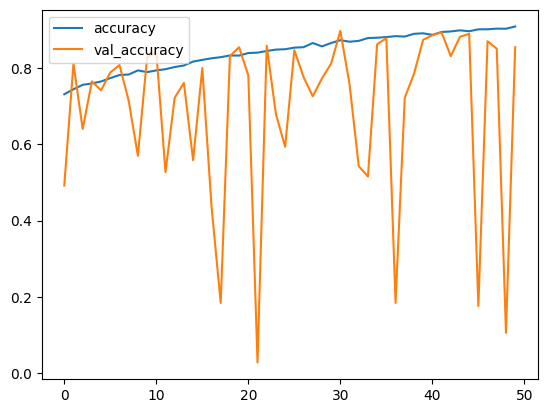

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(loc="upper left")
plt.show()

In [ ]:
fmodel.save('best_model',save_format = 'h5')

# Read model
m1 = load_model(r'/kaggle/working/vgg_model')

In [21]:
prediction = fmodel.predict(testing)

predicted= np.argmax(prediction,axis=1)

9/9 [==============================] - 5s 264ms/step


In [22]:
from sklearn.metrics import accuracy_score
print('accuracy:',accuracy_score(testing.labels,predicted))

accuracy: 0.01509433962264151
